In [8]:
#import module (library)

import pandas as pd
import pycaret
import numpy as np
import math
import matplotlib.pyplot as plt
from pycaret.regression import *

from pycaret.regression import load_model

import plotly.io as pio
pio.renderers.default = 'iframe_connected'

import time

from datetime import datetime

In [2]:
# import module (user defined function)

from py_module.load_data import load_data
from py_module.plot_data import plot_histogram
from py_module.regression import *
from py_module.pre_processing import *
from py_module.verify import *

In [3]:
# import raw_data (from csv file)

filename = "./Data_2021_10_14_v1 (N98923)/Data.csv" # csv file directory and name

raw_data = load_data(fn=filename, pp=1)


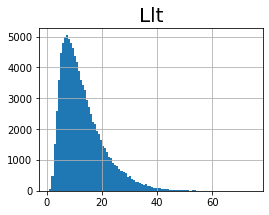

In [4]:
# plot raw_data histogram (for data pre-process / option-task)

## - parameter
# input : N1, N2, d1, d2, freq, move_tx, move_rx, offset_tx, offset_rx, per, space1, space2, space3, space4, l1, l2, h1, w1
# output : Lmt, Lmr, Llt, Llr, k, R1, R2

## - opt
# bins : (default : 100)
# plt_size : (default : [6,5])
# grid_en : (default : False)
# title_en : (default : False)
# title : (default : "")
# fontsize : (default : {}) (see : https://www.delftstack.com/ko/howto/matplotlib/how-to-set-the-figure-title-and-axes-labels-font-size-in-matplotlib/)

parameter = "Llt" # desired parameter as a histogram
title = parameter # plot title name
fontsize = {'axes.titlesize' : 20, 'xtick.labelsize' : 10, 'ytick.labelsize' : 10}


plot_histogram(raw_data, parameter, plt_size=[4,3], grid_en=True, title_en=True, title=title, fontsize=fontsize)

In [5]:
## === dataset pre-processing ===

# drop output data except for target output

parameter = "Llt" # target output pamareter
processed_data = drop_output(raw_data, parameter)



# cut data
## - opt
# lo : lower bound value (default : -inf)
# hi : upper bound value (default : inf)

processed_data = cut_data(processed_data, parameter="Llt", lo=0.1, hi=40)



# add feature
# 기존에 존재하는 input parameter들을 이용해서 물리적인 의미를 갖는 새로운 파라미터를 만들어 낼 시 모델의 성능을 증가시킬 수 있음
# ex> 변압기 자화 인덕턴스는 턴수의 제곱에 비례하므로 턴수의 제곱에 해당하는 파라미터를 새로 만들어 자화인덕터 regression 모델을 만들 경우 모델 성능 증가

new_feature_names = []

processed_data = add_feature(processed_data, parameter, new_feature_names = new_feature_names)



processed_data




,N1,N2,d1,d2,freq,move_tx,move_rx,offset_tx,offset_rx,per,space1,space2,space3,space4,l1,l2,h1,w1,Llt
0,8,8,6.0,9.7,49000.0,2,5,7,-9,1480,1,23,3,55,19,41,166,24,6.704324
1,8,8,11.7,10.7,49000.0,6,4,18,-5,1160,5,47,3,31,31,72,251,248,13.703235
2,8,8,9.0,5.4,49000.0,4,1,9,-18,4192,5,31,7,28,33,40,191,212,19.559244
3,8,8,9.5,4.2,49000.0,6,3,14,-7,3419,1,21,6,38,15,30,185,221,16.173505
4,11,11,7.5,10.3,58000.0,1,2,13,-17,4445,7,50,6,46,16,69,207,241,35.181363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97610,9,9,8.4,9.2,42000.0,7,2,8,-14,2483,9,59,9,35,30,71,235,105,14.449801
97611,5,5,11.4,8.9,25000.0,3,4,12,-6,1838,2,50,3,47,23,62,161,118,7.164551
97612,5,5,8.6,9.6,25000.0,2,2,17,-2,4913,1,21,3,35,29,51,110,80,3.697227
97613,5,5,11.0,3.6,25000.0,1,7,18,-12,4437,1,33,4,31,26,59,131,170,8.532143


In [9]:
# regression data

## - opt
# algorithm : regression algorithm (default : "ligthgbm")
# frac_ratio : train set / test set ratio (default : 0.9)
# silent : (default : True)
# save_en : whether to save the trained model as a file (.pkl) : (default : False)
# save_model_name : model file name : (default : "model")
# new_feature_names : to avoid number of features error (default : [])

## - algorithm list (see detail : https://pycaret.readthedocs.io/en/latest/api/regression.html)
# 'lr' - Linear Regression
# 'lasso' - Lasso Regression
# 'ridge' - Ridge Regression
# 'en' - Elastic Net
# 'lar' - Least Angle Regression
# 'llar' - Lasso Least Angle Regression
# 'omp' - Orthogonal Matching Pursuit
# 'br' - Bayesian Ridge
# 'ard' - Automatic Relevance Determination
# 'par' - Passive Aggressive Regressor
# 'ransac' - Random Sample Consensus
# 'tr' - TheilSen Regressor
# 'huber' - Huber Regressor
# 'kr' - Kernel Ridge
# 'svm' - Support Vector Regression
# 'knn' - K Neighbors Regressor
# 'dt' - Decision Tree Regressor
# 'rf' - Random Forest Regressor
# 'et' - Extra Trees Regressor
# 'ada' - AdaBoost Regressor
# 'gbr' - Gradient Boosting Regressor
# 'mlp' - MLP Regressor
# 'xgboost' - Extreme Gradient Boosting
# 'lightgbm' - Light Gradient Boosting Machine
# 'catboost' - CatBoost Regressor


[model, data_seen, data_unseen] = regression_basic(processed_data, parameter, algorithm="lightgbm", frac_ratio=0.9, save_en=False, save_model_name="model", new_feature_names=new_feature_names)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1339,0.0488,0.2210,0.9890,0.0547,0.0860
1,0.1360,0.0483,0.2198,0.9894,0.0562,0.0896
2,0.1346,0.0433,0.2080,0.9902,0.0541,0.0867
3,0.1371,0.0488,0.2209,0.9893,0.0567,0.0855
4,0.1357,0.0393,0.1982,0.9912,0.0516,0.0859
5,0.1361,0.0416,0.2038,0.9907,0.0563,0.0895
6,0.1387,0.0455,0.2133,0.9899,0.0534,0.0860
7,0.1414,0.0504,0.2246,0.9891,0.0562,0.0880
8,0.1381,0.0497,0.2229,0.9890,0.0555,0.0857
9,0.1390,0.0442,0.2102,0.9904,0.0520,0.0857


In [10]:
# verify model

verify_model(model, data_seen, data_unseen, parameter)

array([0.99042782, 0.12938798, 0.0429489 , 0.20724116, 8.23238559])

In [11]:
# tune model

## - opt
# n_iter : (default : 10)
# optimize : (default : "R2")
# early_stopping : (default : False)
# choose_better : (default : False)
# verbose : (default : False)

tuned_model = tune_model(model, n_iter=10000, optimize="MAE", early_stopping=False, choose_better=True, verbose=True)

verify_model(tuned_model, data_seen, data_unseen, parameter)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0835,0.0286,0.1690,0.9935,0.0348,0.0426
1,0.0831,0.0277,0.1666,0.9939,0.0371,0.0450
2,0.0837,0.0220,0.1485,0.9950,0.0333,0.0425
3,0.0838,0.0263,0.1621,0.9943,0.0367,0.0420
4,0.0829,0.0170,0.1305,0.9962,0.0293,0.0435
5,0.0817,0.0197,0.1405,0.9956,0.0344,0.0435
6,0.0831,0.0226,0.1504,0.9950,0.0319,0.0414
7,0.0853,0.0272,0.1649,0.9941,0.0345,0.0434
8,0.0845,0.0273,0.1651,0.9940,0.0363,0.0431
9,0.0844,0.0218,0.1478,0.9953,0.0306,0.0415


array([0.99630842, 0.06721511, 0.01656355, 0.12869947, 3.72980966])

In [12]:
array([0.99536475, 0.0737844 , 0.02079766, 0.14421394, 3.80649947])

NameError: name 'array' is not defined

In [ ]:
algorithm_list = models().index

algorithm_list[algorithm_list!="lr"]

Index(['lasso', 'ridge', 'en', 'lar', 'llar', 'omp', 'br', 'ard', 'par',
       'ransac', 'tr', 'huber', 'kr', 'svm', 'knn', 'dt', 'rf', 'et', 'ada',
       'gbr', 'mlp', 'lightgbm'],
      dtype='object', name='ID')

In [9]:
# compare algorithm (tuned case)
# 여러 regression 알고리즘 중 가장 높은 성능을 내는 알고리즘 탐색 (모든 알고리즘 탐색)
# 각각의 algorithm은 auto tune을 이용하여 튜닝

# activate logger
[model, data_seen, data_unseen] = regression_basic(processed_data, parameter, algorithm="lightgbm", frac_ratio=0.9, save_en=False, save_model_name="model", new_feature_names=new_feature_names)


# variable
algorithm_list = models().index
except_list = ["kr","svm","huber","rf","et"] # algorithm list to exclude from train
result = []


# eleminate algorithm in exception list
for al_name in except_list :

    algorithm_list = algorithm_list[algorithm_list!=al_name]

algorithm_list = ["lightgbm"]
    
# train each algorithm
for al_name in algorithm_list :

    start_time = time.time()

    [model, data_seen, data_unseen] = regression_basic(processed_data, parameter, algorithm=al_name, new_feature_names=new_feature_names)
    print(f'{al_name} : {datetime.now()}')
    tuned_model = tune_model(model, n_iter=1000, optimize="MAE", early_stopping=False, choose_better=True, verbose=True, search_library="scikit-optimize", search_algorithm="bayesian")
    [R2, MAE, MSE, RMSE, MPE] = verify_model(tuned_model, data_seen, data_unseen, parameter)

    end_time= time.time()
    timetime = end_time - start_time

    result.append([al_name, R2, MAE, MSE, RMSE, MPE, timetime])


# compare model result
pd.DataFrame(result,columns = ["algorithm","R2","MAE","MSE","RMSE","MPE(%)","time(s)"]).sort_values(by='R2' ,ascending=False).reset_index(drop=True)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7227,1.1163,1.0566,0.9788,0.0743,0.0632
1,0.7299,1.1384,1.0669,0.9785,0.0715,0.0611
2,0.7380,1.1633,1.0785,0.9788,0.0730,0.0621
3,0.7279,1.1925,1.0920,0.9766,0.0754,0.0633
4,0.7335,1.1579,1.0761,0.9778,0.0724,0.0615
5,0.7364,1.2226,1.1057,0.9764,0.0731,0.0619
6,0.7259,1.1502,1.0725,0.9783,0.0744,0.0623
7,0.7321,1.1340,1.0649,0.9781,0.0745,0.0634
8,0.7266,1.2335,1.1106,0.9764,0.0760,0.0630
9,0.7114,1.1359,1.0658,0.9791,0.0722,0.0608


lightgbm : 2022-01-12 19:14:23.831555


IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:14:23
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.4s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.2s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.7s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.1s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.4s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.9s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.8s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.8s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.9s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished
